### 1. Data reading


First load and normalize our training and test data using `torchvision` .


In [1]:
# !pip install torchsummary

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchsummary import summary
from utils import show_examples, UnNormalize

In [3]:
transform = transforms.Compose([
#     transforms.CenterCrop(224),
    transforms.RandomCrop(32,padding=4),
    transforms.RandomHorizontalFlip(),  
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]) 

In [4]:
Batch_Size = 64

In [5]:
trainset = datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
testset = datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=Batch_Size,shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=Batch_Size,shuffle=True, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified



### 2. View data (format, size, shape)


In [6]:
classes = trainset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [7]:
trainset.class_to_idx


{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [8]:
trainset.data.shape #50000 is the number of pictures, 32x32 is the picture size, 3 is the number of channels RGB

(50000, 32, 32, 3)

In [9]:
print(type(trainset.data))
print(type(trainset))

<class 'numpy.ndarray'>
<class 'torchvision.datasets.cifar.CIFAR10'>



### Summarize:

### 3. View pictures


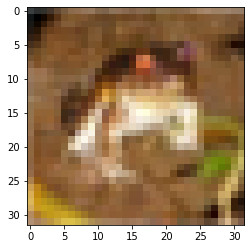

In [10]:
import numpy as np
import matplotlib.pyplot as plt
plt.imshow(trainset.data[0])
im,label = iter(trainloader).next()

In [11]:
def imshow(img):
    img = img / 2 + 0.5
    img = np.transpose(img.numpy(),(1,2,0))
    plt.imshow(img)

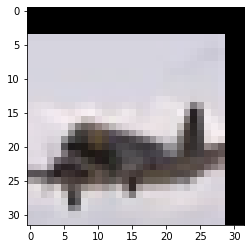

In [12]:
imshow(im[0])

In [13]:
im[0].shape

torch.Size([3, 32, 32])

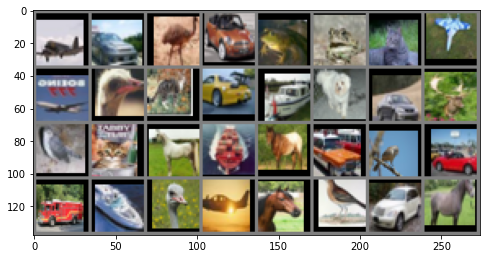

In [14]:
plt.figure(figsize=(8,12))
imshow(torchvision.utils.make_grid(im[:32]))

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [16]:
# define the neural network
class AlexNet(nn.Module): # Train ALexNet
    '''
    5 layers of convolution, 3 layers of fully connected
    '''
    def __init__(self):
        super(AlexNet, self).__init__()
        # five convolutional layers input 32 *32* 3
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, stride=1, padding=1), # (32-3+2)/1+1 = 32
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0) # (32-2)/2+1 = 16
        )
        self.conv2 = nn.Sequential( # input 16 *16* 6
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1, padding=1), # (16-3+2)/1+1 = 16
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0) # (16-2)/2+1 = 8
        )
        self.conv3 = nn.Sequential( # input 8 *8* 16
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1), # (8-3+2)/1+1 = 8
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0) # (8-2)/2+1 = 4
        )
        self.conv4 = nn.Sequential( # input 4 *4* 64
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # (4-3+2)/1+1 = 4
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0) # (4-2)/2+1 = 2
        )
        self.conv5 = nn.Sequential( # input 2 *2* 128
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),# (2-3+2)/1+1 = 2
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0) # (2-2)/2+1 = 1
        ) # last convolutional layer, output 1 *1* 128
        # fully connected layer
        self.dense = nn.Sequential(
            nn.Linear(128, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.view(x.size()[0],-1)
        x = self.dense(x)
        return x
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    

net = AlexNet().to(device)

In [17]:
summary(net,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 32, 32]             168
              ReLU-2            [-1, 6, 32, 32]               0
         MaxPool2d-3            [-1, 6, 16, 16]               0
            Conv2d-4           [-1, 16, 16, 16]             880
              ReLU-5           [-1, 16, 16, 16]               0
         MaxPool2d-6             [-1, 16, 8, 8]               0
            Conv2d-7             [-1, 32, 8, 8]           4,640
              ReLU-8             [-1, 32, 8, 8]               0
         MaxPool2d-9             [-1, 32, 4, 4]               0
           Conv2d-10             [-1, 64, 4, 4]          18,496
             ReLU-11             [-1, 64, 4, 4]               0
        MaxPool2d-12             [-1, 64, 2, 2]               0
           Conv2d-13            [-1, 128, 2, 2]          73,856
             ReLU-14            [-1, 12

In [18]:
print(net)

AlexNet(
  (conv1): Sequential(
    (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil

In [19]:
test_x = torch.randn(1,3,32,32).to(device)
test_y = net(test_x)
print(test_y.shape)

torch.Size([1, 10])


In [20]:
net =AlexNet().to(device)
if device == 'cuda':
    net = nn.DataParallel(net)
    torch.backends.cudnn.benchmark = True


### 5. Define the loss function and optimizer

 Pytorch encapsulates all the optimization methods commonly used in deep learning in torch.optim, and all optimization methods inherit the base class optim.Optimizier

 The loss function is encapsulated in the neural network toolbox nn, which contains many loss functions


In [21]:
import torch.optim as optim
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5 ,patience = 5,min_lr = 0.000001) 
import time
epoch = 50


### 6. Training


In [22]:
import os
if not os.path.exists('./model'):
    os.makedirs('./model')
else:
    print('The file already exists')
save_path = './model/AlexNet.pth'

The file already exists


In [23]:
from utils import train
from utils import plot_history

Acc, Loss, Lr = train(net, trainloader, testloader, epoch, optimizer, criterion, scheduler, save_path, verbose = True)

Epoch [  1/ 50]  Train Loss:2.302863  Train Acc:9.92% Test Loss:2.301425  Test Acc:13.59%  Learning Rate:0.010000	Time 00:09
Epoch [  2/ 50]  Train Loss:2.138030  Train Acc:18.24% Test Loss:1.955998  Test Acc:23.91%  Learning Rate:0.010000	Time 00:10
Epoch [  3/ 50]  Train Loss:1.832553  Train Acc:28.57% Test Loss:1.817346  Test Acc:31.60%  Learning Rate:0.010000	Time 00:10
Epoch [  4/ 50]  Train Loss:1.629932  Train Acc:38.38% Test Loss:1.549248  Test Acc:41.32%  Learning Rate:0.010000	Time 00:10
Epoch [  5/ 50]  Train Loss:1.469552  Train Acc:45.28% Test Loss:1.421378  Test Acc:47.37%  Learning Rate:0.010000	Time 00:11
Epoch [  6/ 50]  Train Loss:1.355507  Train Acc:50.24% Test Loss:1.405771  Test Acc:49.06%  Learning Rate:0.010000	Time 00:11
Epoch [  7/ 50]  Train Loss:1.259315  Train Acc:54.61% Test Loss:1.288533  Test Acc:54.43%  Learning Rate:0.010000	Time 00:10
Epoch [  8/ 50]  Train Loss:1.199456  Train Acc:57.00% Test Loss:1.162648  Test Acc:58.77%  Learning Rate:0.010000	Time

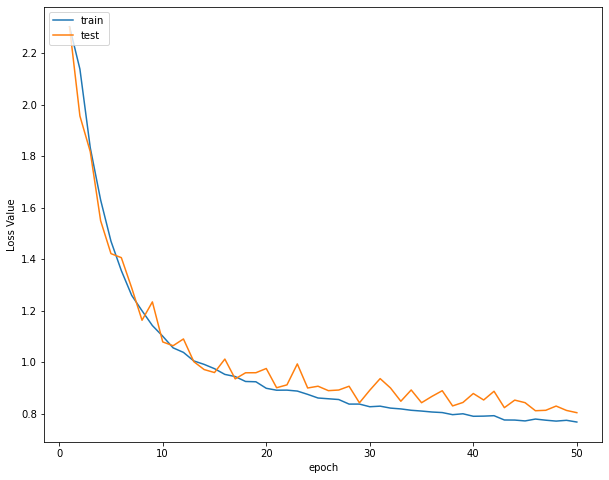

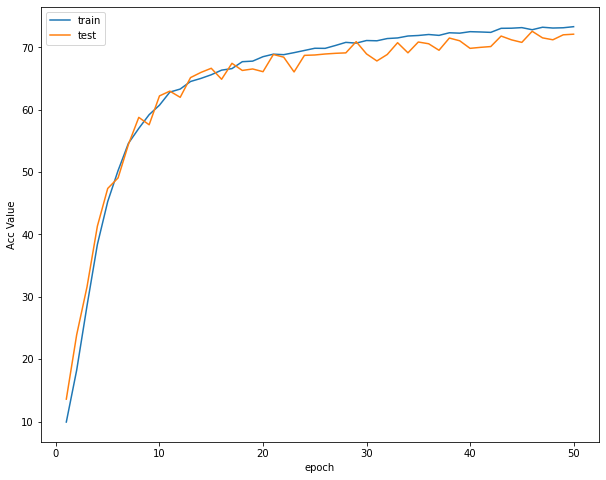

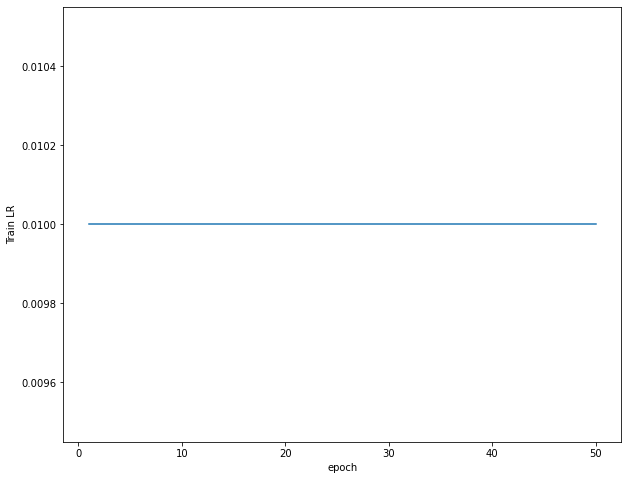

In [24]:
plot_history(epoch ,Acc, Loss, Lr)

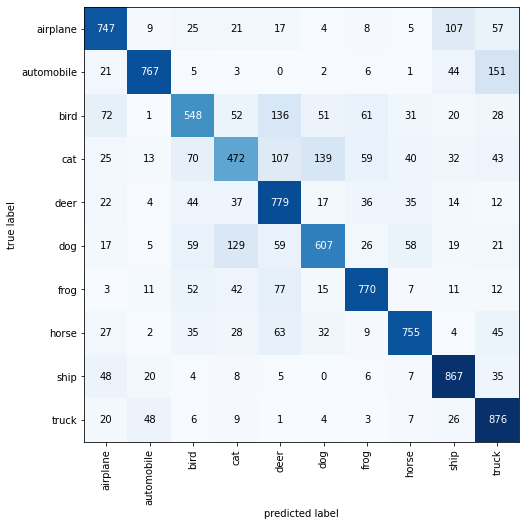

In [25]:
from utils import compute_confusion_matrix
from utils import plot_confusion_matrix

class_dict = {0: 'airplane',
              1: 'automobile',
              2: 'bird',
              3: 'cat',
              4: 'deer',
              5: 'dog',
              6: 'frog',
              7: 'horse',
              8: 'ship',
              9: 'truck'}

mat = compute_confusion_matrix(model=net, data_loader=testloader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()


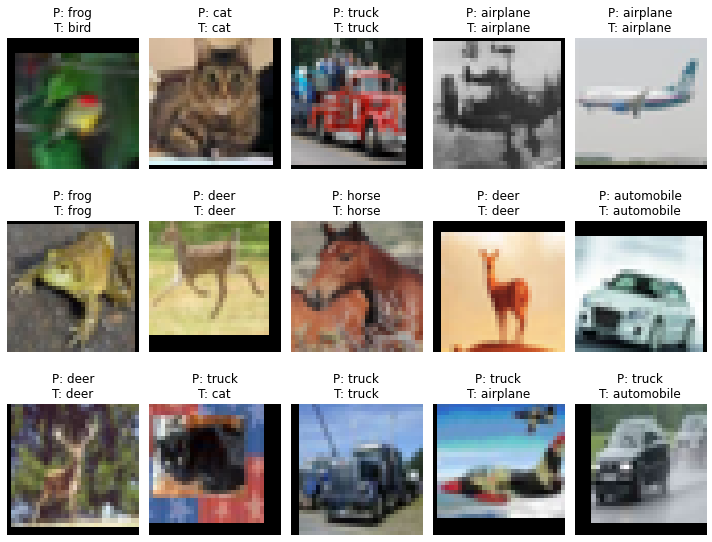

In [26]:
unnormalizer = UnNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

show_examples(model=net, data_loader=testloader, unnormalizer=unnormalizer, class_dict=class_dict)


### 7. Test


In [27]:
correct = 0 # Define the number of correctly predicted images, initialized to 0 
total = 0 # The total number of pictures participating in the test, also initialized to 0
testloader = torch.utils.data.DataLoader(testset, batch_size=32,shuffle=True, num_workers=2)

for data in testloader: # Loop through each batch 
    images, labels = data 
    images = images.to(device) 
    labels = labels.to(device) 
    net.eval() 
    # Convert the model to test mode 
    if hasattr(torch.cuda, 'empty_cache'): 
        torch.cuda.empty_cache() 
    outputs = net(images) # Enter the network for testing
    # outputs.data is a 4x10 tensor. The value and sequence number of the largest column of each row are formed into a one-dimensional tensor to return, the first is the value tensor, and the second is the sequence number tensor
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0) # update the number of test images
    correct += (predicted == labels).sum() # update the number of correctly classified images

print('Accuracy of the network on the 10000 test images: %.2f %%' % (100 * correct / total))


Accuracy of the network on the 10000 test images: 71.78 %


In [28]:
# Define 2 lists that store the number of correct tests in each class, initialized to 0
class_correct = list(0.for i in range(10))
class_total = list(0.for i in range(10))
# testloader = torch.utils.data.DataLoader(testset, batch_size=64,shuffle=True, num_workers=2)
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
    #4 group (batch_size) data, output in the same label, marked as 1, otherwise 0
        c = (predicted == labels).squeeze()
        for i in range(len(images)): # Because each batch has 4 images, a small loop of 4 is needed
            label = labels[i] # Accumulate each class separately
            class_correct[label] += c[i]
            class_total[label] += 1
 
 
for i in range(10):
    print('Accuracy of %5s : %.2f %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of airplane : 72.70 %
Accuracy of automobile : 79.00 %
Accuracy of  bird : 56.60 %
Accuracy of   cat : 49.50 %
Accuracy of  deer : 77.20 %
Accuracy of   dog : 59.90 %
Accuracy of  frog : 76.80 %
Accuracy of horse : 74.70 %
Accuracy of  ship : 86.60 %
Accuracy of truck : 88.40 %


Accuracy Rate = 71.875%


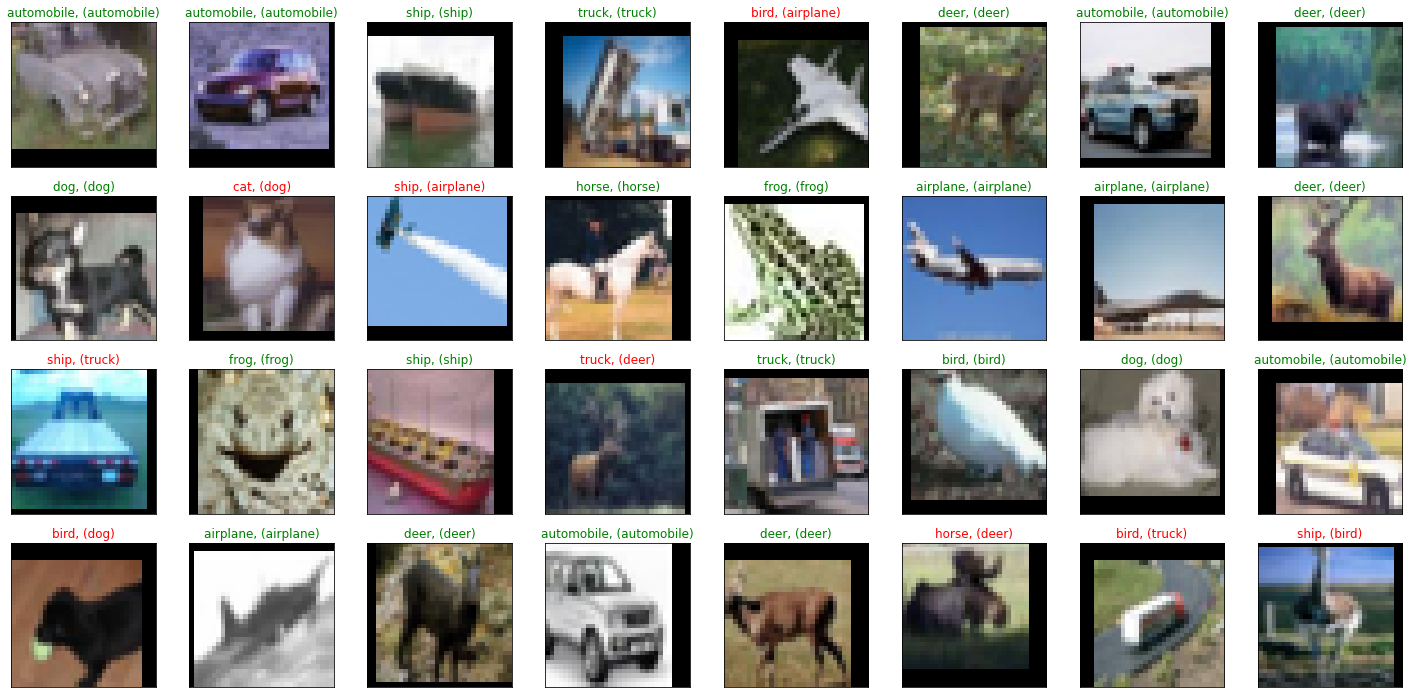

In [29]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images_ = images
#images_ = images_.view(images.shape[0], -1)
images_ = images_.to(device)
labels = labels.to(device)
val_output = net(images_)
_, val_preds = torch.max(val_output, 1)


correct = torch.sum(val_preds == labels.data).item()

print("Accuracy Rate = {}%".format(correct/len(images) * 100))

fig = plt.figure(figsize=(25,25))
for idx in np.arange(32):    
    ax = fig.add_subplot(8, 8, idx+1, xticks=[], yticks=[])
    #fig.tight_layout()
#     plt.imshow(im_convert(images[idx]))
    imshow(images[idx])
    ax.set_title("{}, ({})".format(classes[val_preds[idx].item()], classes[labels[idx].item()]), 
                 color = ("green" if val_preds[idx].item()==labels[idx].item() else "red"))

In [30]:
Acc

{'train_acc': [9.92447280883789,
  18.236492156982422,
  28.568572998046875,
  38.38115310668945,
  45.278533935546875,
  50.239768981933594,
  54.60957336425781,
  57.001277923583984,
  59.19916915893555,
  60.725704193115234,
  62.82168960571289,
  63.30722427368164,
  64.52205657958984,
  65.01358795166016,
  65.5990219116211,
  66.3423080444336,
  66.58607482910156,
  67.69501495361328,
  67.78492736816406,
  68.49823760986328,
  68.89985656738281,
  68.82192993164062,
  69.14562225341797,
  69.49528503417969,
  69.8469467163086,
  69.83296203613281,
  70.29651641845703,
  70.79403686523438,
  70.67215728759766,
  71.08975219726562,
  71.0457992553711,
  71.40544891357422,
  71.50335693359375,
  71.81305694580078,
  71.89698028564453,
  72.05482482910156,
  71.91496276855469,
  72.33255767822266,
  72.26862335205078,
  72.50839233398438,
  72.46043395996094,
  72.39649963378906,
  73.0458755493164,
  73.06385803222656,
  73.15776824951172,
  72.8200912475586,
  73.21971130371094,
 


### 8. Save the model


In [31]:
torch.save(net,save_path[:-4]+'_'+str(epoch)+'.pth')
# torch.save(net, './model/ResNet34.pth')